In [1]:
using ElectricGrid
using PlotlyJS

Basic setup for a small electric grid with one source and one load. 
And ofcourse a cable inbetween.

In [2]:
CM = [0. 1.
     -1. 0.]

S_source = 1e4
S_load = 1e2
pf_load = 1
v_rms = 230
R_load, L_load, X, Z = ParallelLoadImpedance(S_load, pf_load, v_rms);

Here we set up any environment with nonlinear values.

In [12]:
parameters_linear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_linear = ElectricGridEnv(CM = CM, parameters = parameters_linear, verbosity = 2);

┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:357
┌ Info: Time simulation run time: 0.0499 [s] ~> 500 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:358


In [14]:
env_linear.nc.parameters

Dict{Any, Any} with 4 entries:
  "source" => Any[Dict{Any, Any}("L1"=>0.00683065, "C"=>7.70615e-6, "mode"=>"Sw…
  "load"   => Any[Dict{Any, Any}("Z"=>1587.0, "v_limit"=>10000.0, "i_limit"=>0.…
  "grid"   => Dict{Any, Any}("f_grid"=>50, "Δfmax"=>0.5, "fs"=>10000.0, "proces…
  "cable"  => Any[Dict{Any, Any}("C"=>0.0001, "len"=>0.466765, "L"=>0.0001, "R"…

Here we set up the environment the same except the inductance of the cable (L) is set to an orbitrary function. In this example its just a constant function to show, that it gives a similar result.

And another key feature is, that you can set a solver for the nonlinear simulation. Which is show in an INFO. (the default one is SSPRK22) more are found here [Differential Equations](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/).

In [15]:
parameters_nonlinear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => x->1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_nonlinear = ElectricGridEnv(CM = CM, parameters = parameters_nonlinear, t_end = 0.04, verbosity = 2, nonlinear_solver = SSPRK33());

┌ Info: Nonlinear Solver: Use SSPRK33 as solver.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:166
┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:357
┌ Info: Time simulation run time: 0.04 [s] ~> 401 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:358


In [18]:
agent_nonlinear = SetupAgents(env_linear)
agent_nonlinear.agents

┌ Info: 1 'classically' controlled source has been initialised.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/classical_control.jl:2674
┌ Info: 1 source has been set up in Swing mode.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/classical_control.jl:2685
┌ Info: All 'classically' controlled sources have been automatically set up with droop coeficients, and proportional and integral gains.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/classical_control.jl:2697


Dict{Any, Any} with 1 entry:
  "typename" => Dict{Any, Any}("policy"=>typename(NamedPolicy)…

In [11]:
agent_nonlinear = SetupAgents(env_nonlinear);
hook = Simulate(agent_nonlinear, env_nonlinear);
RenderHookResults(hook = hook, 
                    states_to_plot  = ["source1_i_L1_a"], # Inductor current [A]
                    actions_to_plot = ["source1_u_a"],    # Inverter voltage [V]
                    )

┌ Info: 1 'classically' controlled source has been initialised.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/classical_control.jl:2674
┌ Info: 1 source has been set up in Swing mode.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/classical_control.jl:2685
┌ Info: All 'classically' controlled sources have been automatically set up with droop coeficients, and proportional and integral gains.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/classical_control.jl:2697


KeyError: KeyError: key "classic" not found

In [5]:
# value = 5

# sol_linear = []
# for i = 1:500
#     env_linear([0.5, 0.5, 0.5])
#     append!(sol_linear,env_linear.x[value])
# end

In [6]:
sol_nonlinear = []
for i = 1:500
    env_nonlinear([0.5, 0.5, 0.5])
    append!(sol_nonlinear,env_nonlinear.x[value])
end

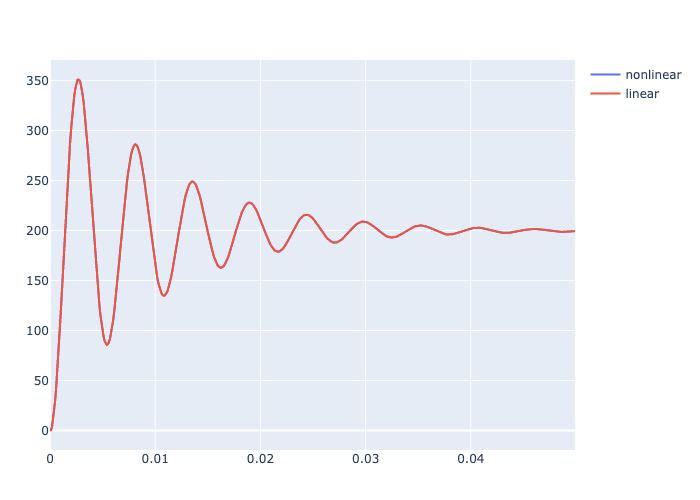

In [7]:
t_nonlinear = collect(env_nonlinear.t0:env_nonlinear.ts:env_nonlinear.t)
p_nonlinear = scatter(x=t_nonlinear,y=sol_nonlinear,mode="lines",name="nonlinear")

t_linear = collect(env_linear.t0:env_linear.ts:env_linear.t)
p_linear = scatter(x=t_linear,y=sol_linear,mode="lines",name="linear")

plot([p_nonlinear,p_linear])

Other orbitrary function...


In [8]:
function NonlinearInductance(value, drop, length)
    return x -> value*(1-drop/100) + value*(drop/100)*1/(1+exp(-(abs(x)-length/2)/2))
end

p = 80
l = NonlinearInductance(0.0001,p,600)

#11 (generic function with 1 method)

vielleicht noch dazu schreiben, dass man immer die nicht linearität des Bauteils mit der daran anliegenden Spannung oder durchfließenden Stroms in die funktionen einspeist.